In [166]:
!pip install vectorbt

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import vectorbt as vbt
import time
import yfinance as yf
import torch
import torch.nn as nn

| Interval       | Max Lookback Period (approx)  |
|----------------|-------------------------------|
| `'1m'`         | 7 days                        |
| `'2m'`         | 60 days                       |
| `'5m'`         | 60 days                       |
| `'15m'`        | 60 days                       |
| `'30m'`        | 60 days                       |
| `'60m'` / `'1h'` | 730 days (~2 years)        |
| `'1d'`         | ~20+ years                    |
| `'1wk'`        | ~20+ years                    |
| `'1mo'`        | ~20+ years                    |

In [168]:
#data_request = vbt.BinanceData.download("BTCUSDT", start="2025-04-14", end="2025-04-17", interval="1m")
data_request = vbt.YFData.download("BTC-USD", start="2025-04-14", end="2025-04-17", interval="1m")
data = data_request.get()
print(data.head())
print(data["Volume"].iloc[-1])
time.sleep(3)

data_request = data_request.update()
data = data_request.get()
print(data["Volume"].iloc[-1])


                                   Open          High           Low  \
Datetime                                                              
2025-04-14 00:01:00+00:00  83706.945312  83706.945312  83706.945312   
2025-04-14 00:03:00+00:00  83729.085938  83729.085938  83729.085938   
2025-04-14 00:04:00+00:00  83800.125000  83800.125000  83800.125000   
2025-04-14 00:06:00+00:00  83708.820312  83708.820312  83708.820312   
2025-04-14 00:07:00+00:00  83785.421875  83785.421875  83785.421875   

                                  Close     Volume  Dividends  Stock Splits  
Datetime                                                                     
2025-04-14 00:01:00+00:00  83706.945312          0        0.0           0.0  
2025-04-14 00:03:00+00:00  83729.085938  132960256        0.0           0.0  
2025-04-14 00:04:00+00:00  83800.125000  678313984        0.0           0.0  
2025-04-14 00:06:00+00:00  83708.820312   23078912        0.0           0.0  
2025-04-14 00:07:00+00:00  83785.4

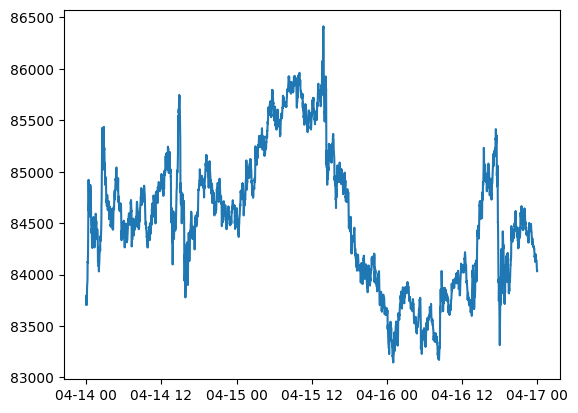

In [169]:
data.vbt.ohlcv.plot(plot_type="candlestick",show_volume=True)
plt.plot(data.index,data["Close"])

size_test_prct = 0.3
lookback = 20 # choose sequence length

input = pd.DataFrame(index = data.index, data = {"Close":data["Close"]})
input = (input-input.min())/(input.max()-input.min())

In [170]:
def split_data(input, lookback, size_test_prct):
    data_raw = np.array(input) # convert to numpy array
    data = []
    lookback+=1 # +1 for output variable

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)

    test_set_size = int(np.round(size_test_prct*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    print(x_train.shape)
    print(y_train.shape)
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    print(x_test.shape)
    print(y_test.shape)

    return [x_train, y_train, x_test, y_test]

In [171]:
lookback = 20 # choose sequence length
size_test_prct = 0.3

x_train, y_train, x_test, y_test = split_data(input, lookback, size_test_prct)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

(2736, 20, 1)
(2736, 1)
(1172, 20, 1)
(1172, 1)


In [172]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [173]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [176]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

#MSE
hist_mse = np.zeros(num_epochs)
MSE = torch.nn.MSELoss(reduction='mean')

#RMSE = squared de MSE
hist_rmse = np.zeros(num_epochs)

#MAE
hist_mae = np.zeros(num_epochs)
MAE = torch.nn.L1Loss(reduction='mean')

#R2
hist_r2 = np.zeros(num_epochs)

#MAPE
hist_mape = np.zeros(num_epochs)

lstm = []

Epoch 1 / MSE: 0.00055 / RMSE: 0.02347 / MAE: 0.01634
Epoch 2 / MSE: 0.00055 / RMSE: 0.02343 / MAE: 0.01631
Epoch 3 / MSE: 0.00055 / RMSE: 0.02339 / MAE: 0.01628
Epoch 4 / MSE: 0.00055 / RMSE: 0.02336 / MAE: 0.01626
Epoch 5 / MSE: 0.00054 / RMSE: 0.02332 / MAE: 0.01623
Epoch 6 / MSE: 0.00054 / RMSE: 0.02329 / MAE: 0.01620
Epoch 7 / MSE: 0.00054 / RMSE: 0.02325 / MAE: 0.01618
Epoch 8 / MSE: 0.00054 / RMSE: 0.02321 / MAE: 0.01615
Epoch 9 / MSE: 0.00054 / RMSE: 0.02318 / MAE: 0.01612
Epoch 10 / MSE: 0.00054 / RMSE: 0.02314 / MAE: 0.01610
Epoch 11 / MSE: 0.00053 / RMSE: 0.02311 / MAE: 0.01607
Epoch 12 / MSE: 0.00053 / RMSE: 0.02307 / MAE: 0.01604
Epoch 13 / MSE: 0.00053 / RMSE: 0.02304 / MAE: 0.01602
Epoch 14 / MSE: 0.00053 / RMSE: 0.02300 / MAE: 0.01599
Epoch 15 / MSE: 0.00053 / RMSE: 0.02297 / MAE: 0.01596
Epoch 16 / MSE: 0.00053 / RMSE: 0.02293 / MAE: 0.01594
Epoch 17 / MSE: 0.00052 / RMSE: 0.02290 / MAE: 0.01591
Epoch 18 / MSE: 0.00052 / RMSE: 0.02286 / MAE: 0.01588
Epoch 19 / MSE: 0.0

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

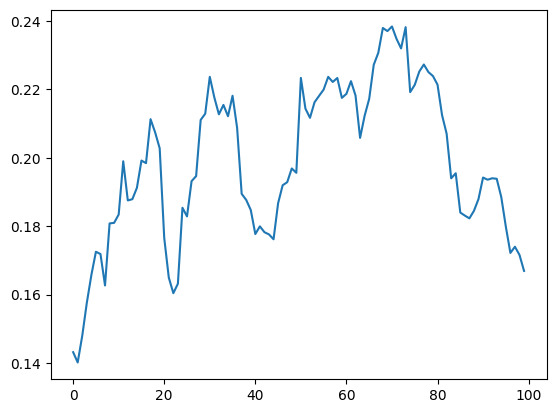

In [186]:
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model(x_train)

    mse_value = MSE(y_train_pred, y_train)
    rmse_value = np.sqrt(mse_value.item())
    mae_value = MAE(y_train_pred, y_train)

    print(f"Epoch {t+1} / MSE: {mse_value.item():.5f} / RMSE: {rmse_value:.5f} / MAE: {mae_value.item():.5f}")

    hist_mse[t] = mse_value.item()
    hist_rmse[t] = rmse_value.item()
    hist_mae[t] = mae_value.item()

    optimiser.zero_grad()
    mse_value.backward()
    optimiser.step()

training_time = time.time()-start_time

print("Training time: {}".format(training_time))
plt.plot(y_train[-lookback*5:],label=f"train {lookback}th last")
plt.plot(y_train_pred[-lookback*5:],label=f"train pred {lookback}th last")
plt.legend()
plt.show()

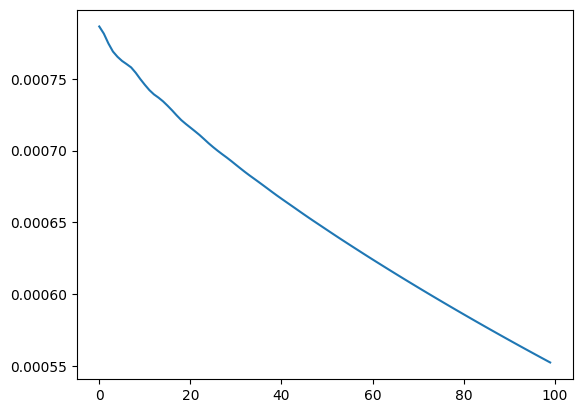

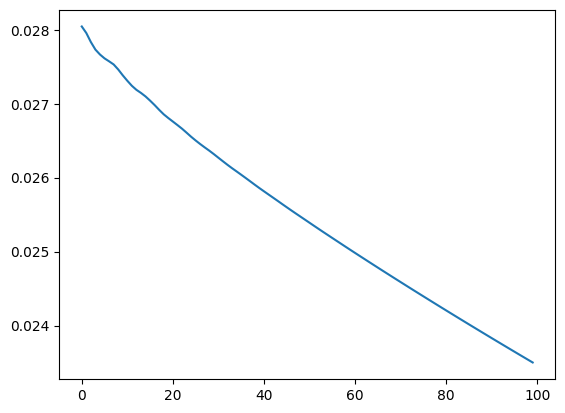

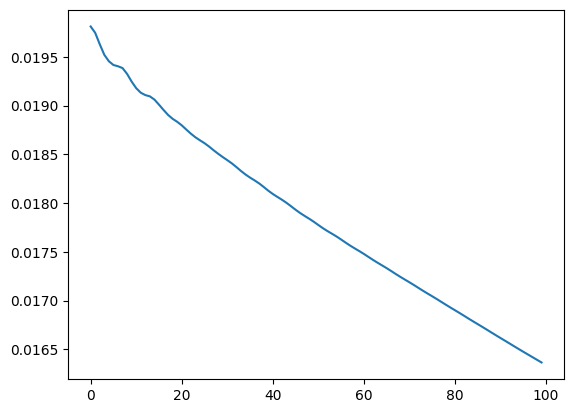

In [181]:
plt.plot(hist_mse)
plt.show()
plt.plot(hist_rmse)
plt.show()
plt.plot(hist_mae)
plt.show()